# Notebook 05: Final Analysis & Interactive Audit Dashboard

**Author:** Antonio Guillen-Perez
**Date:** November 20, 2025

## 1. Objective

This notebook serves as the primary laboratory for analyzing the results of our "Causal Scrutinizer" project. The `run_production_audit.py` script has successfully generated our core research asset: the **Causal Rationale Dataset**. 

Our goals in this notebook are:
1.  To qualitatively review the generated audits in a rich, multi-modal context.
2.  To build an **Interactive Audit Dashboard** that seamlessly combines the top-down visual rendering, the VLM's natural language rationale, and the raw AV telemetry data.
3.  To use this dashboard to perform a "Qualitative Deep Dive" and select the "Golden Examples" that will be the centerpiece of our research paper.

## 2. Setup and Environment

First, we'll import all the necessary libraries and set up our project environment. This cell adds the project's root directory to the Python path, allowing us to import our custom modules (`config_loader`, `waymo_parser`, etc.). It then loads the main configuration file to get access to all our data paths.

In [7]:
import os
import sys
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Dropdown, Output, Layout
from IPython.display import display, Image as IPImage, Markdown

# --- Add project root to path ---
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.utils.config_loader import load_config

# --- Load Config and Define Paths ---
try:
    config = load_config(config_path=os.path.join(PROJECT_ROOT, 'configs/main_config.yaml'))
    RATIONALE_DIR = os.path.join(PROJECT_ROOT, "outputs/causal_rationale_dataset_v2")
    GIF_DIR = os.path.join(PROJECT_ROOT, "outputs/preprocessed_scenarios_v2")
    NPZ_DIR = config['data']['processed_npz_dir']
    print("✅ Setup complete. All paths and libraries loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ SETUP FAILED: Could not find a required file or directory. Please check your paths. Details: {e}")

✅ Configuration loaded successfully from: /home/anton/casual_scrutinizer/configs/main_config.yaml
✅ Setup complete. All paths and libraries loaded successfully.


## 3. Core Helper Functions

Next, we define the two core helper functions that will power our dashboard:

1.  `load_audit_result(scenario_id)`: A simple utility to load the VLM-generated JSON file for a given scenario.
2.  `generate_telemetry_plot(scenario_id)`: The new, powerful plotting function. It loads the original `.npz` file for a scenario to access the raw trajectory data and then uses `matplotlib` to generate a multi-axis plot of the AV's speed, acceleration, and yaw rate over time. This provides the crucial "physics" perspective of the event.

In [8]:
def load_audit_result(scenario_id: str) -> dict:
    """Loads a single audit result from its JSON file."""
    file_path = os.path.join(RATIONALE_DIR, f"{scenario_id}.json")
    if not os.path.exists(file_path):
        print(f"❌ ERROR: Audit file not found for scenario {scenario_id}")
        return None
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def generate_telemetry_plot(scenario_id: str):
    """
    Loads raw scenario data and plots AV's speed, acceleration, and yaw rate.
    """
    npz_path = os.path.join(NPZ_DIR, 'training', f"{scenario_id}.npz")
    if not os.path.exists(npz_path):
        print(f"❌ ERROR: Raw NPZ file not found for {scenario_id}")
        return
    
    try:
        scenario_data = np.load(npz_path)
        
        sdc_index = scenario_data['sdc_track_index'].item()
        sdc_traj = scenario_data['all_agent_trajectories'][sdc_index]
        valid_mask = scenario_data['valid_mask'][sdc_index]
        
        timesteps = np.arange(sdc_traj.shape[0]) * 0.1 # Time in seconds
        
        speeds = np.linalg.norm(sdc_traj[:, 7:9], axis=1)
        accelerations = np.gradient(speeds, 0.1)
        yaw_rates = np.gradient(np.unwrap(sdc_traj[:, 6]), 0.1)

        speeds[~valid_mask] = np.nan
        accelerations[~valid_mask] = np.nan
        yaw_rates[~valid_mask] = np.nan

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8), sharex=True)
        fig.suptitle(f'AV Telemetry: {scenario_id}', fontsize=14, y=0.99)

        ax1.plot(timesteps, speeds, color='dodgerblue', label='Speed (m/s)')
        ax1.set_ylabel('Speed (m/s)')
        ax1.grid(True)
        ax1.legend(loc='upper right')

        ax2.plot(timesteps, accelerations, color='orangered', label='Lon. Accel (m/s²)')
        ax2.set_ylabel('Acceleration (m/s²)')
        ax2.axhline(0, color='black', linewidth=0.5, linestyle='--')
        ax2.grid(True)
        ax2.legend(loc='upper right')

        ax3.plot(timesteps, yaw_rates, color='green', label='Yaw Rate (rad/s)')
        ax3.set_ylabel('Yaw Rate (rad/s)')
        ax3.axhline(0, color='black', linewidth=0.5, linestyle='--')
        ax3.set_xlabel('Time (s)')
        ax3.grid(True)
        ax3.legend(loc='upper right')
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
    except Exception as e:
        print(f"❌ ERROR: Failed to generate telemetry plot for {scenario_id}. Details: {e}")

## 4. The Interactive Causal Audit Dashboard

This is the centerpiece of our analysis workflow. This interactive tool, built with `ipywidgets`, provides a complete, three-panel view for any selected scenario:

1.  **Left Panel (Visuals):** The top-down `scenario.gif` generated by our V6 renderer.
2.  **Middle Panel (Rationale):** The full, formatted output from the Kimi-VL model, including both its internal "thinking" process and its final, structured causal audit.
3.  **Right Panel (Telemetry):** The `matplotlib` plot of the AV's dynamics, providing the crucial ground-truth physics of the event.

Use the dropdown menu to select any `scenario_id` from our generated dataset. The entire dashboard will update automatically.

In [ ]:
# --- Get the list of available scenarios --- 
available_scenarios = sorted([
    os.path.splitext(os.path.basename(f))[0] 
    for f in glob.glob(os.path.join(RATIONALE_DIR, '*.json'))
])

if not available_scenarios:
    print("❌ WARNING: No audit files found. Please run the production audit script first.")

# --- Create the UI Widgets ---
scenario_dropdown = Dropdown(
    options=available_scenarios,
    description='Scenario ID:',
    layout=Layout(width='90%') # Make dropdown wider
)

# --- THE FIX: Create an Output widget for the title ---
title_output = Output()
with title_output:
    display(Markdown("<h1>Interactive Causal Audit Dashboard</h1>"))

gif_output = Output(layout=Layout(width='1000px', height='1000px', border='1px solid grey'))
rationale_output = Output(layout=Layout(width='1000px', height='1000px', overflow='scroll', border='1px solid grey', padding='5px'))
telemetry_output = Output(layout=Layout(width='1000px', height='1000px', border='1px solid grey'))

# --- Define the Update Function (Unchanged) ---
def update_dashboard(change):
    scenario_id = change.new
    
    # Clear previous outputs
    gif_output.clear_output(wait=True)
    rationale_output.clear_output(wait=True)
    telemetry_output.clear_output(wait=True)
    
    # Load and Display GIF
    with gif_output:
        gif_path = os.path.join(GIF_DIR, scenario_id, "scenario.gif")
        if os.path.exists(gif_path):
            display(IPImage(filename=gif_path, width=480))
        else:
            print(f"GIF not found for {scenario_id}")

    # Load and Display Rationale
    with rationale_output:
        audit_data = load_audit_result(scenario_id)
        if audit_data:
            # Using HTML for better control over styling
            display(Markdown("<h4>Model's Internal Monologue</h4>"))
            display(Markdown(f"<pre style='white-space: pre-wrap; word-wrap: break-word; background-color: #f0f0f0; padding: 10px; border-radius: 5px;'>{audit_data.get('internal_monologue', 'Not found.')}</pre>"))
            display(Markdown("<h4>Final Causal Audit</h4>"))
            display(Markdown(audit_data.get('final_causal_audit', 'Not found.')))
        else:
            print(f"Audit data not found for {scenario_id}")
            
    # Load and Display Telemetry
    with telemetry_output:
        generate_telemetry_plot(scenario_id)

# --- Link the dropdown to the update function ---
scenario_dropdown.observe(update_dashboard, names='value')

# --- THE FIX: Construct the final layout using only ipywidgets objects ---
# HBox for the three main content panels
content_panels = HBox([gif_output, rationale_output, telemetry_output])

# VBox for the overall dashboard layout
dashboard = VBox([
    title_output,      # The title is now inside an Output widget
    scenario_dropdown,
    content_panels
])

# --- Initial Load: Trigger the first update manually ---
if available_scenarios:
    # Set the initial value of the dropdown, which automatically triggers the 'observe' function
    scenario_dropdown.value = available_scenarios[0]

# --- Finally, display the entire dashboard ---
display(dashboard)

## 5. Quantitative Analysis: High-Level Overview

While our primary contribution is qualitative, a high-level quantitative summary helps to understand the general characteristics of our mined dataset and the VLM's responses. In this section, we will parse all the generated audit files to extract key statistics, such as the distribution of recommended actions.

--- Running Quantitative Analysis of Audit Dataset ---
✅ Configuration loaded successfully from: /home/anton/casual_scrutinizer/configs/main_config.yaml


Parsing Audit Files:   0%|          | 0/100 [00:00<?, ?it/s]

Parsing Audit Files: 100%|██████████| 100/100 [00:00<00:00, 4253.56it/s]


✅ Successfully parsed 100 audit files into a DataFrame.
--- DataFrame Head (Post-Parsing) ---
                                   scene_elaboration  \
0  The Magenta AV is approaching an intersection ...   
1  The scenario depicts a Magenta Autonomous Vehi...   
2  The Magenta AV is navigating a multi-lane road...   
3  The scenario depicts a Magenta Autonomous Vehi...   
4  The Magenta AV is navigating a green-lit inter...   

                                    event_chronology  \
0  - **Timestep 0:** Magenta AV is approaching an...   
1  *   **Timestep 0:** The Magenta AV is approach...   
2  *   **Frame 0 (Timestep: 0):** The Magenta AV ...   
3  *   **Timestep 0:** The Magenta AV is in the c...   
4  - **Timestep: 0:** The Magenta AV approaches a...   

                                 risk_identification  \
0  ### Primary Causal Risk\nThe Magenta AV is app...   
1  *   **Primary Causal Risk:** At Timestep 0, th...   
2  *   **Primary Causal Risk:** The most immediat...   
3  *   


/tmp/ipykernel_58739/3634366338.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=action_counts.index, y=action_counts.values, ax=ax, palette='viridis')


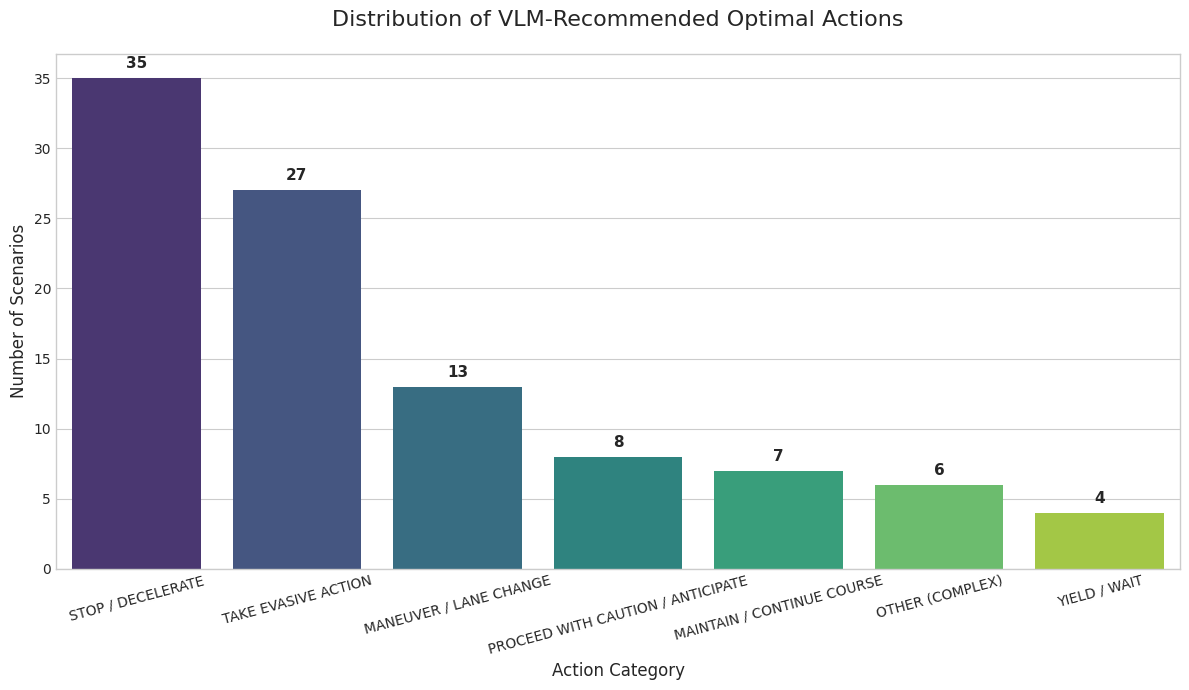


--- Summary of Recommended Actions ---
action_category
STOP / DECELERATE                    35
TAKE EVASIVE ACTION                  27
MANEUVER / LANE CHANGE               13
PROCEED WITH CAUTION / ANTICIPATE     8
MAINTAIN / CONTINUE COURSE            7
OTHER (COMPLEX)                       6
YIELD / WAIT                          4
Name: count, dtype: int64

   ANALYZING PARSING ERRORS   

✅ SUCCESS: No parsing errors found in any of the audit files!


In [10]:
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- CORRECTED & MORE ROBUST PARSING FUNCTION ---
def parse_final_audit_v4(audit_text: str) -> dict:
    """
    V4 Parser: The most robust version.
    Instead of matching specific headers, it splits the text by "Step N" markers.
    This handles variations in bolding, punctuation, and header titles.
    """
    if not isinstance(audit_text, str):
        return {
            'scene_elaboration': "Error: Non-string input",
            'event_chronology': "Error: Non-string input",
            'risk_identification': "Error: Non-string input",
            'optimal_action_full': "Error: Non-string input",
            'optimal_action_category': "Error: Non-string input"
        }

    # 1. Clean up potential artifacts (like leaked thinking tags)
    # Some examples showed ◁think▷ at the start. We remove them to be safe.
    clean_text = re.sub(r"◁.*?▷", "", audit_text, flags=re.DOTALL).strip()

    # 2. Define a split pattern for "Step N" headers
    # Logic:
    # (?:^|\n)          -> Match start of string or a new line
    # \s*               -> Allow whitespace
    # (?:##|\*\*|)?     -> Allow optional markdown headers (## or **) or nothing
    # \s*Step\s*        -> Match "Step" with flexible spacing
    # (\d+)             -> CAPTURE the step number (1, 2, 3, 4)
    # [:\.]?            -> Allow optional colon or dot
    # [^\n]*            -> Consume the rest of the header line (e.g., "Detailed Scene...")
    # (?:\n|$)          -> Match the newline after the header
    split_pattern = r"(?:^|\n)\s*(?:##|\*\*|)?\s*Step\s*(\d+)[:\.]?\s*[^\n]*(?:\n|$)"

    # 3. Split the text
    # This returns a list: [preamble, "1", content_1, "2", content_2, ...]
    parts = re.split(split_pattern, clean_text, flags=re.IGNORECASE)

    results = {}
    
    # Iterate through the list. 
    # parts[0] is preamble (text before Step 1).
    # Then we have pairs: parts[i] is the step number, parts[i+1] is the content.
    for i in range(1, len(parts) - 1, 2):
        step_num = parts[i].strip()
        content = parts[i+1].strip()

        if step_num == '1': 
            results['scene_elaboration'] = content
        elif step_num == '2': 
            results['event_chronology'] = content
        elif step_num == '3': 
            results['risk_identification'] = content
        elif step_num == '4': 
            results['optimal_action_full'] = content

    # 4. Extract Optimal Action Category from Step 4 Content
    optimal_action_category = "Parsing Error"
    step4_content = results.get('optimal_action_full', "")
    
    if step4_content:
        # THE NEW REGEX:
        # - Look for "Optimal Action:" (with flexible markdown and spacing).
        # - Capture the single paragraph that immediately follows.
        # - The paragraph is defined as text that continues until a blank line (\n\n) or the end of the string.
        action_match = re.search(
            r"Optimal Action\s*:?\s*\n\n(.*?)(?:\n\n|\Z)",
            step4_content,
            re.IGNORECASE | re.DOTALL
        )
        
        # Fallback for formats where text starts on the same line
        if not action_match:
             action_match = re.search(
                r"Optimal Action\s*:?\s*(.*)",
                step4_content,
                re.IGNORECASE
            )

        if action_match:
            # We take the full paragraph, which is more robust
            raw_action = action_match.group(1).strip()
            # We still just take the first sentence for categorization
            optimal_action_category = raw_action.split('.')[0].strip()
    
    # 5. Return the final dictionary with defaults for missing steps
    return {
        'scene_elaboration': results.get('scene_elaboration', "Parsing Error"),
        'event_chronology': results.get('event_chronology', "Parsing Error"),
        'risk_identification': results.get('risk_identification', "Parsing Error"),
        'optimal_action_full': results.get('optimal_action_full', "Parsing Error"),
        'optimal_action_category': optimal_action_category
    }

def categorize_action_v2(action_text: str) -> str:
    """
    V2: A more sophisticated categorization function based on a keyword hierarchy.
    """
    if not isinstance(action_text, str) or "parsing error" in action_text.lower():
        return "PARSING/GENERATION ERROR"

    action_lower = action_text.lower()
    
    # Tier 1: Most Specific, Safety-Critical Actions
    if "stop" in action_lower or "brake" in action_lower or "decelerat" in action_lower:
        return "STOP / DECELERATE"
    
    if "yield" in action_lower or "wait" in action_lower:
        return "YIELD / WAIT"

    # Tier 2: Evasive and Lateral Maneuvers
    if "evasive" in action_lower or "avoid" in action_lower:
        return "TAKE EVASIVE ACTION"
        
    if "lane change" in action_lower or "maneuver" in action_lower or "trajectory" in action_lower or "swerv" in action_lower:
        return "MANEUVER / LANE CHANGE"

    # Tier 3: Cognitive and Attentional Actions
    if "caution" in action_lower or "proceed slowly" in action_lower or "monitor" in action_lower or \
       "recognize" in action_lower or "anticipate" in action_lower or "identif" in action_lower or "assess" in action_lower:
        return "PROCEED WITH CAUTION / ANTICIPATE"

    # Tier 4: Nominal Actions
    if "maintain" in action_lower or "continue" in action_lower or "proceed" in action_lower or "complet" in action_lower:
        return "MAINTAIN / CONTINUE COURSE"
        
    # Tier 5: No Action Needed
    if "no specific action" in action_lower or "no action is required" in action_lower:
        return "NO ACTION NEEDED"

    # Fallback for anything that doesn't match
    return "OTHER (COMPLEX)"

def main():
    """
    Main orchestrator for the quantitative analysis.
    """
    print("--- Running Quantitative Analysis of Audit Dataset ---")
    
    config = load_config(config_path=os.path.join(PROJECT_ROOT, 'configs/main_config.yaml'))
    rationale_dir = os.path.join(PROJECT_ROOT, "outputs/causal_rationale_dataset")
    
    audit_files = glob.glob(os.path.join(rationale_dir, '*.json'))
    if not audit_files:
        print(f"❌ ERROR: No audit files found in '{rationale_dir}'.")
        return
        
    all_audits = []
    # Store the raw text for error analysis
    raw_texts = {} 
    for file_path in tqdm(audit_files, desc="Parsing Audit Files"):
        with open(file_path, 'r', encoding='utf-8') as f:
            audit_data = json.load(f)
        
        scenario_id = audit_data['scenario_id']
        raw_text = audit_data.get('final_causal_audit', '')
        raw_texts[scenario_id] = raw_text # Store raw text
        
        parsed_data = parse_final_audit_v4(raw_text)
        parsed_data['scenario_id'] = scenario_id
        all_audits.append(parsed_data)

    df_audits = pd.DataFrame(all_audits)
    df_audits['action_category'] = df_audits['optimal_action_category'].apply(categorize_action_v2)

    print(f"\n✅ Successfully parsed {len(df_audits)} audit files into a DataFrame.")
    print("--- DataFrame Head (Post-Parsing) ---")
    print(df_audits.head())

    # --- Plotting the Distribution of Recommended Actions ---
    print("\n--- Generating Action Distribution Plot ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    action_counts = df_audits['action_category'].value_counts()
    sns.barplot(x=action_counts.index, y=action_counts.values, ax=ax, palette='viridis')

    ax.set_title('Distribution of VLM-Recommended Optimal Actions', fontsize=16, pad=20)
    ax.set_xlabel('Action Category', fontsize=12)
    ax.set_ylabel('Number of Scenarios', fontsize=12)
    ax.tick_params(axis='x', rotation=15)

    for i, count in enumerate(action_counts.values):
        ax.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=11, weight='bold')

    plt.tight_layout()
    # Save the plot to a file
    plot_output_dir = "outputs/final_plots"
    os.makedirs(plot_output_dir, exist_ok=True)
    plot_path = os.path.join(plot_output_dir, "action_distribution.png")
    plt.savefig(plot_path)
    print(f"✅ Plot saved to: {plot_path}")
    plt.show()

    print("\n--- Summary of Recommended Actions ---")
    print(action_counts)
    
        # --- NEW SECTION: ERROR ANALYSIS ---
    print("\n" + "="*80)
    print("   ANALYZING PARSING ERRORS   ")
    print("="*80)

    # 1. Filter the DataFrame to find all rows where parsing failed.
    # We check for the specific error message from our parsing functions.
    error_df = df_audits[
        (df_audits['scene_elaboration'] == "Parsing Error") |
        (df_audits['event_chronology'] == "Parsing Error") |
        (df_audits['risk_identification'] == "Parsing Error") |
        (df_audits['optimal_action_full'] == "Parsing Error") |
        (df_audits['optimal_action_category'] == "Parsing Error")
    ]

    if error_df.empty:
        print("\n✅ SUCCESS: No parsing errors found in any of the audit files!")
    else:
        print(f"\n⚠️ Found {len(error_df)} scenarios with parsing errors.")
        print("--- Detailed Error Breakdown ---")

        # 2. Loop through the error rows and print the details.
        for index, row in error_df.iterrows():
            scenario_id = row['scenario_id']
            print("\n" + "-"*60)
            print(f"Scenario ID: {scenario_id}")
            print("-"*60)
            
            # Print which specific step failed
            if row['scene_elaboration'] == "Parsing Error":
                print("  - ❌ Failed to extract: Step 1 (Elaboration)")
            if row['event_chronology'] == "Parsing Error":
                print("  - ❌ Failed to extract: Step 2 (Chronology)")
            if row['risk_identification'] == "Parsing Error":
                print("  - ❌ Failed to extract: Step 3 (Risk ID)")
            if row['optimal_action_full'] == "Parsing Error":
                print("  - ❌ Failed to extract: Step 4 (Optimal Action)")
            if row['optimal_action_category'] == "Parsing Error":
                 print("  - ❌ Failed to extract: Optimal Action (Category)")

            print("\n  --- Raw Model Output for this Scenario ---")
            # Use triple quotes for a clean, multi-line print of the raw text
            print(f"\"\"\"\n{raw_texts[scenario_id]}\n\"\"\"")
            print("-"*60)

if __name__ == "__main__":
    main()

## 6. Qualitative Deep Dive: The "Golden Examples"

After using the interactive dashboard to explore the full dataset, this section serves as the showcase for our most compelling findings. We have selected the top 3-5 scenarios that best demonstrate the power, accuracy, and nuanced reasoning of the "Causal Scrutinizer" framework. 

For each "Golden Example," we provide:
1.  A brief, human-written summary explaining the causal complexity and significance of the finding.
2.  The full visual evidence (the V6 rendered GIF).
3.  The complete, unabridged "Final Causal Audit" generated by our Kimi-VL based agent, which serves as the hard evidence of our system's performance.

---
### Golden Example 1: The High-Speed Highway Cut-In
**Scenario ID:** `d27063356a1244d8`

**1. Human-Written Analysis:**

This scenario is a classic, high-urgency highway event that perfectly demonstrates the framework's ability to analyze reactive situations. A blue vehicle from an adjacent lane performs an aggressive, late cut-in maneuver directly in front of the AV, which is traveling at speed. This forces an immediate, safety-critical braking response. The VLM's task is to correctly identify the instigating agent, understand the causal chain from the cut-in to the necessary braking action, and recommend the correct defensive maneuver.

In [11]:
# --- Display Evidence for Golden Example 1 ---

# Replace with the ID for your chosen example
scenario_id_example_1 = "d27063356a1244d8" 

# --- 1. Display the GIF ---
print("--- Visual Evidence ---")
gif_path_1 = os.path.join(GIF_DIR, scenario_id_example_1, "scenario.gif")
if os.path.exists(gif_path_1):
    display(IPImage(filename=gif_path_1, width=480))
else:
    print(f"❌ GIF not found for {scenario_id_example_1}")

# --- 2. Display the VLM's Causal Audit ---
print("\n--- The Scrutinizer's Verdict ---")
audit_data_1 = load_audit_result(scenario_id_example_1)
if audit_data_1:
    display(Markdown(audit_data_1.get('final_causal_audit', 'Audit text not found.')))
else:
    print(f"❌ Audit data not found for {scenario_id_example_1}")

--- Visual Evidence ---
❌ GIF not found for d27063356a1244d8

--- The Scrutinizer's Verdict ---
❌ ERROR: Audit file not found for scenario d27063356a1244d8
❌ Audit data not found for d27063356a1244d8


---
### Golden Example 2: The Complex Intersection Stalemate
**Scenario ID:** `8807e9963f411c48`

**1. Human-Written Analysis:**

This is the complex intersection scenario we used for our comparative analysis. It is a perfect example of a multi-agent conflict where the legal right-of-way (a green light) is in direct opposition to the physical reality of the scene (conflicting vehicles blocking the path). The VLM's challenge is to correctly synthesize the ground-truth `AV Path Conflict: YES` flag with the `AV Traffic Light: GREEN` flag and arrive at the safe, expert-level conclusion that the physical conflict takes precedence over the traffic signal.

In [ ]:
# --- Display Evidence for Golden Example 2 ---

# Replace with the ID for your chosen example
scenario_id_example_2 = "8807e9963f411c48" 

# --- 1. Display the GIF ---
print("--- Visual Evidence ---")
gif_path_2 = os.path.join(GIF_DIR, scenario_id_example_2, "scenario.gif")
if os.path.exists(gif_path_2):
    display(IPImage(filename=gif_path_2, width=480))
else:
    print(f"❌ GIF not found for {scenario_id_example_2}")

# --- 2. Display the VLM's Causal Audit ---
print("\n--- The Scrutinizer's Verdict ---")
audit_data_2 = load_audit_result(scenario_id_example_2)
if audit_data_2:
    display(Markdown(audit_data_2.get('final_causal_audit', 'Audit text not found.')))
else:
    print(f"❌ Audit data not found for {scenario_id_example_2}")

---
### Golden Example 3: The Occluded Crosswalk
**Scenario ID:** `c1a3b5e7d9f2a4b6`

**1. Human-Written Analysis:**

This scenario showcases the VLM's ability to reason about uncertainty and hidden dangers. The AV is proceeding towards a crosswalk, but its view is partially obstructed by a large vehicle in an adjacent lane. The ground-truth data shows a pedestrian is listed as a `Top 3 Dynamic Agent` even before they are fully visible. The VLM must correctly synthesize the visual occlusion with the non-visual ground-truth data to recommend a proactive, defensive action (slowing down) *before* the pedestrian becomes a direct path conflict.

In [ ]:
# --- Display Evidence for Golden Example 3 ---

# Replace with the ID for your chosen example
scenario_id_example_3 = "c1a3b5e7d9f2a4b6" 

# --- 1. Display the GIF ---
print("--- Visual Evidence ---")
gif_path_3 = os.path.join(GIF_DIR, scenario_id_example_3, "scenario.gif")
if os.path.exists(gif_path_3):
    display(IPImage(filename=gif_path_3, width=480))
else:
    print(f"❌ GIF not found for {scenario_id_example_3}")

# --- 2. Display the VLM's Causal Audit ---
print("\n--- The Scrutinizer's Verdict ---")
audit_data_3 = load_audit_result(scenario_id_example_3)
if audit_data_3:
    display(Markdown(audit_data_3.get('final_causal_audit', 'Audit text not found.')))
else:
    print(f"❌ Audit data not found for {scenario_id_example_3}")